## Imports

In [1]:
pip install "numpy<2"

Note: you may need to restart the kernel to use updated packages.


In [11]:
import numpy as np
import cv2
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score
from skimage.feature import graycomatrix, graycoprops, local_binary_pattern
import os
from PIL import Image

In [31]:
import sklearn
print(sklearn.__version__)


1.4.2


## Intermediary Step - Download Data
- https://www.kaggle.com/datasets/ultralytics/brain-tumor/data?select=brain-tumor.yaml
- put it into a folder called "ml_project_data"

## Load and Split Data

In [3]:
TARGET_SIZE = (224, 224)  # H, W

def read_label_from_yolo_txt(path):
    """Read class label from YOLO format .txt file"""
    with open(path, "r") as f:
        lines = [ln.strip() for ln in f.readlines() if ln.strip()]
    first_line = lines[0]
    parts = first_line.split()
    class_id = int(float(parts[0]))  # 0 = no tumor, 1 = tumor
    return class_id

def load_split_to_numpy(split_root):
    """
    Load images and labels from train/ or test/ directory
    Returns: X (N, H, W) grayscale images, y (N,) labels
    """
    images_dir = os.path.join(split_root, "images")
    labels_dir = os.path.join(split_root, "labels")

    image_files = sorted([f for f in os.listdir(images_dir)
                          if f.lower().endswith((".jpg", ".png"))])

    X_list, y_list = [], []

    for fname in image_files:
        img_path = os.path.join(images_dir, fname)
        base = os.path.splitext(fname)[0]
        label_path = os.path.join(labels_dir, base + ".txt")

        if not os.path.exists(label_path):
            print(f"WARNING: Missing label for {fname}")
            continue

        # Load grayscale and resize to fixed size
        img = Image.open(img_path).convert("L")
        img = img.resize(TARGET_SIZE)
        X_list.append(np.array(img))

        label = read_label_from_yolo_txt(label_path)
        y_list.append(label)

    X = np.stack(X_list, axis=0)  # (N, 224, 224)
    y = np.array(y_list, dtype=int)  # (N,)
    
    print(f"Loaded {len(X)} images from {split_root}")
    print(f"  Class 0 (no tumor): {np.sum(y == 0)}")
    print(f"  Class 1 (tumor): {np.sum(y == 1)}")
    
    return X, y

In [4]:
    X_train_raw, y_train = load_split_to_numpy("ml_project_data/brain-tumor/train")
    X_test_raw, y_test = load_split_to_numpy("ml_project_data/brain-tumor/valid")
    
    print(f"\nDataset summary:")
    print(f"  Training: {X_train_raw.shape}, labels: {y_train.shape}")
    print(f"  Test:     {X_test_raw.shape}, labels: {y_test.shape}")

Loaded 878 images from ml_project_data/brain-tumor/train
  Class 0 (no tumor): 419
  Class 1 (tumor): 459
Loaded 223 images from ml_project_data/brain-tumor/valid
  Class 0 (no tumor): 142
  Class 1 (tumor): 81

Dataset summary:
  Training: (878, 224, 224), labels: (878,)
  Test:     (223, 224, 224), labels: (223,)


## Image Preprocessing

In [5]:
def preprocess_image(img):
    """
    Preprocess a single image (already grayscale and resized)
    - Denoise
    - Normalize
    - Enhance contrast
    
    Input: img (H, W) uint8 numpy array [0-255]
    Output: img (H, W) float32 numpy array [0-1]
    """
    # Denoise
    img_denoised = cv2.GaussianBlur(img, (5, 5), 0)
    
    # Normalize to [0, 1]
    img_normalized = img_denoised.astype(np.float32) / 255.0
    
    # CLAHE for contrast enhancement
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    img_uint8 = (img_normalized * 255).astype(np.uint8)
    img_enhanced = clahe.apply(img_uint8)
    
    # Back to [0, 1]
    img_final = img_enhanced.astype(np.float32) / 255.0
    
    return img_final

def preprocess_all_images(X):
    """
    Apply preprocessing to all images
    Input: X (N, H, W)
    Output: X_processed (N, H, W) in [0, 1]
    """
    print(f"Preprocessing {len(X)} images...")
    processed = []
    for i, img in enumerate(X):
        if i % 500 == 0:
            print(f"  Processing {i}/{len(X)}")
        processed.append(preprocess_image(img))
    return np.array(processed)

In [6]:
X_train_processed = preprocess_all_images(X_train_raw)
X_test_processed = preprocess_all_images(X_test_raw)

Preprocessing 878 images...
  Processing 0/878
  Processing 500/878
Preprocessing 223 images...
  Processing 0/223


## Feature Extraction w/ Graycom Matrix

In [25]:
def extract_statistical_features(img):
    """Extract first-order statistical features"""
    features = []
    
    # Convert to uint8 for calculations
    img_uint8 = (img * 255).astype(np.uint8)
    
    features.append(np.mean(img_uint8))
    features.append(np.std(img_uint8))
    features.append(np.median(img_uint8))
    features.append(np.var(img_uint8))
    features.append(np.percentile(img_uint8, 25))
    features.append(np.percentile(img_uint8, 75))
    features.append(np.min(img_uint8))
    features.append(np.max(img_uint8))
    
    # Histogram-based
    hist = cv2.calcHist([img_uint8], [0], None, [256], [0, 256]).flatten()
    hist = hist / (hist.sum() + 1e-10)  # normalize
    features.append(np.sum(hist ** 2))  # energy
    features.append(-np.sum(hist * np.log2(hist + 1e-10)))  # entropy
    
    return features

def extract_glcm_features(img):
    """
    Extract GLCM texture features at MULTIPLE SCALES
    Research shows multi-scale is critical for accuracy
    """
    features = []
    
    img_uint8 = (img * 255).astype(np.uint8)
    
    # Multiple distances for multi-scale analysis
    angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]
    distances = [1, 2, 3]  # Multi-scale: close, medium, far
    
    # Extract GLCM at each distance
    for dist in distances:
        glcm = graycomatrix(img_uint8, distances=[dist], angles=angles, 
                            levels=256, symmetric=True, normed=True)
        
        # Extract properties at this scale
        properties = ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation']
        
        for prop in properties:
            values = graycoprops(glcm, prop)
            features.append(np.mean(values))  # Average over angles
    
    return features  # 3 distances × 5 properties = 15 features

def extract_lbp_features(img):
    """
    Extract Local Binary Pattern features at MULTIPLE SCALES
    Research shows this captures multi-resolution texture
    """
    img_uint8 = (img * 255).astype(np.uint8)
    
    all_features = []
    
    # Multi-scale LBP: different (n_points, radius) combinations
    scales = [(8, 1), (16, 2), (24, 3)]  # (n_points, radius)
    
    for n_points, radius in scales:
        # Compute LBP at this scale
        lbp = local_binary_pattern(img_uint8, n_points, radius, method='uniform')
        
        # Compute histogram
        n_bins = n_points + 2
        hist, _ = np.histogram(lbp.ravel(), bins=n_bins, range=(0, n_bins), density=True)
        
        # Take top 5 bins (most informative)
        top_indices = np.argsort(hist)[-5:]
        all_features.extend(hist[top_indices])
    
    return all_features  # 3 scales × 5 bins = 15 features

def extract_edge_features(img):
    """Extract edge-based features"""
    features = []
    
    img_uint8 = (img * 255).astype(np.uint8)
    
    # Sobel edge detection
    sobelx = cv2.Sobel(img_uint8, cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(img_uint8, cv2.CV_64F, 0, 1, ksize=3)
    magnitude = np.sqrt(sobelx**2 + sobely**2)
    
    features.append(np.mean(magnitude))
    features.append(np.std(magnitude))
    features.append(np.max(magnitude))
    
    # Edge density
    edges = cv2.Canny(img_uint8, 50, 150)
    edge_density = np.sum(edges > 0) / edges.size
    features.append(edge_density)
    
    return features

def extract_features_from_image(img):
    """
    Extract all features from a single preprocessed image
    Including INTERACTION FEATURES (critical for high accuracy!)
    Input: img (H, W) in [0, 1]
    Output: 1D feature vector
    """
    features = []
    
    # Extract base features first
    stat_features = extract_statistical_features(img)
    glcm_features = extract_glcm_features(img)
    lbp_features = extract_lbp_features(img)
    edge_features = extract_edge_features(img)
    
    # Add base features
    features.extend(stat_features)      # ~10 features
    features.extend(glcm_features)      # ~10 features
    features.extend(lbp_features)       # ~10 features
    features.extend(edge_features)      # ~4 features
    
    # CRITICAL: Add interaction features (outer product of GLCM × LBP)
    # This is what research papers use to achieve 99%+ accuracy!
    glcm_array = np.array(glcm_features)
    lbp_array = np.array(lbp_features)
    
    # Outer product creates all pairwise interactions
    interaction = np.outer(glcm_array, lbp_array).flatten()
    
    # Too many features (10 * 10 = 100), so take top components via variance
    # Keep features with highest variance (most informative)
    if len(interaction) > 30:
        # Simple feature selection: keep top 30 by absolute value
        top_indices = np.argsort(np.abs(interaction))[-30:]
        interaction = interaction[top_indices]
    
    features.extend(interaction.tolist())
    
    # Add non-linear transformations
    # Log transform of GLCM features captures complex relationships
    log_glcm = np.log1p(np.abs(glcm_array))  # log(1 + |x|) to handle negatives
    features.extend(log_glcm.tolist())
    
    return np.array(features)

def extract_features_from_all_images(X):
    """
    Extract features from all images
    Input: X (N, H, W)
    Output: feature_matrix (N, n_features)
    """
    print(f"Extracting features from {len(X)} images...")
    feature_matrix = []
    
    for i, img in enumerate(X):
        if i % 500 == 0:
            print(f"  Processing {i}/{len(X)}")
        features = extract_features_from_image(img)
        feature_matrix.append(features)
    
    feature_matrix = np.array(feature_matrix)
    print(f"Feature extraction complete. Shape: {feature_matrix.shape}")
    return feature_matrix

In [26]:
X_train_features = extract_features_from_all_images(X_train_processed)
X_test_features = extract_features_from_all_images(X_test_processed)
    
print(f"\nFeature matrix shapes:")
print(f"  Train: {X_train_features.shape} ({X_train_features.shape[1]} features per image)")
print(f"  Test:  {X_test_features.shape}")

Extracting features from 878 images...
  Processing 0/878
  Processing 500/878
Feature extraction complete. Shape: (878, 89)
Extracting features from 223 images...
  Processing 0/223
Feature extraction complete. Shape: (223, 89)

Feature matrix shapes:
  Train: (878, 89) (89 features per image)
  Test:  (223, 89)


## Model Training + Hyperparameter Tuning w/ K Fold Cross Validation
- Train Random Forest with hyperparameter tuning via GridSeach CV
- Find the best parameters with K fold cross validation (specficially stratified k fold for classification)

In [23]:
# standard scaler from scikit learn
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# fit and transform on training data
X_train_std = scaler.fit_transform(X_train_features)  # single step: fit and transform X_train

# only transform on test to prevent leakage
X_test_std  = scaler.transform(X_test_features)

# Optional: sanity checks on mean/std of X_train_std
print(X_train_std.mean(axis=0)[:3], X_train_std.std(axis=0)[:3])
# mean should be very close to 0 and std should be very close to 1, represent a standardized distribution

[-2.55174267e-16 -5.63710051e-15  7.40707167e-16] [1. 1. 1.]


In [24]:
from sklearn.model_selection import GridSearchCV

# using 5 folds
cv_folds = 5

# Define the parameter grid of all hyperparameter combinations
param_grid = {
    'n_estimators': [30, 50, 100],
    'max_depth': [3, 5, 7],                   # Shallow trees only
    'min_samples_split': [20, 30, 40],        # Very conservative
    'min_samples_leaf': [10, 15, 20],         # Large leaves
    'max_features': ['sqrt'],                 # Fewer features
    'min_impurity_decrease': [0.01, 0.02]     # Require significant improvement
}
# Define random forest
rf = RandomForestClassifier(
    random_state=42,
    class_weight='balanced',
    n_jobs=-1
)
        
# Stratified K-Fold for consistent class distribution
skf = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)
    
# GridSearchCV - performed on the parameter grid
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=skf,  
    scoring='accuracy',  
    n_jobs=-1,
    verbose=1,
    return_train_score=True
)
    
# train model with different sets of hyperparameters
grid_search.fit(X_train_std, y_train)

# print best result from the grid search
print(f"\nBest parameters found: {grid_search.best_params_}")
print(f"Best cross-validation accuracy: {grid_search.best_score_:.4f}")

# print all tested combinations
print(f"\nAll tested combinations:")
results = grid_search.cv_results_
indices = np.argsort(results['mean_test_score'])[::-1][:5]
for i, idx in enumerate(indices, 1):
    print(f"  {i}. Score: {results['mean_test_score'][idx]:.4f} "
          f"(±{results['std_test_score'][idx]:.4f}) - "
          f"Params: {results['params'][idx]}")
    
# The best model is already trained on the full training set
best_model = grid_search.best_estimator_

# Verify training accuracy
train_pred = best_model.predict(X_train_std)
train_acc = accuracy_score(y_train, train_pred)
print(f"\nTraining accuracy with best parameters: {train_acc:.4f}")

# best_model, grid_search.best_score_, grid_search

Fitting 5 folds for each of 162 candidates, totalling 810 fits

Best parameters found: {'max_depth': 5, 'max_features': 'sqrt', 'min_impurity_decrease': 0.01, 'min_samples_leaf': 10, 'min_samples_split': 20, 'n_estimators': 50}
Best cross-validation accuracy: 0.6343

All tested combinations:
  1. Score: 0.6343 (±0.0499) - Params: {'max_depth': 5, 'max_features': 'sqrt', 'min_impurity_decrease': 0.01, 'min_samples_leaf': 10, 'min_samples_split': 20, 'n_estimators': 50}
  2. Score: 0.6320 (±0.0548) - Params: {'max_depth': 5, 'max_features': 'sqrt', 'min_impurity_decrease': 0.01, 'min_samples_leaf': 10, 'min_samples_split': 30, 'n_estimators': 30}
  3. Score: 0.6320 (±0.0541) - Params: {'max_depth': 5, 'max_features': 'sqrt', 'min_impurity_decrease': 0.01, 'min_samples_leaf': 10, 'min_samples_split': 40, 'n_estimators': 30}
  4. Score: 0.6320 (±0.0572) - Params: {'max_depth': 5, 'max_features': 'sqrt', 'min_impurity_decrease': 0.01, 'min_samples_leaf': 10, 'min_samples_split': 20, 'n_esti

## Test and Metrics

In [27]:
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score, log_loss

y_test_pred  = best_model.predict(X_test_std)

test_acc = accuracy_score(y_test, y_test_pred, normalize=True, sample_weight=None)
y_test_proba = best_model.predict_proba(X_test_std)[:, 1]
precision = precision_score(y_test, y_test_pred)
recall_score = recall_score(y_test, y_test_pred)
f1_score = f1_score(y_test, y_test_pred)
loss = log_loss(y_test, y_test_pred, normalize=True)


print(f"Train accuracy: {train_acc:.4f}")
print(f"Test accuracy : {test_acc:.4f}")
print(f"Test ROC-AUC:", roc_auc_score(y_test, y_test_proba))
print(f"Precision : {precision:.4f}")
print(f"Recall Score : {recall_score:.4f}")
print(f"F1 Score : {f1_score:.4f}")
print(f"Cross Entropy Loss : {loss:.4f}")

Train accuracy: 0.6777
Test accuracy : 0.6233
Test ROC-AUC: 0.6172839506172839
Precision : 0.4815
Recall Score : 0.4815
F1 Score : 0.4815
Cross Entropy Loss : 13.5770


In [28]:
# confustion martrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_test_pred)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[100  42]
 [ 42  39]]


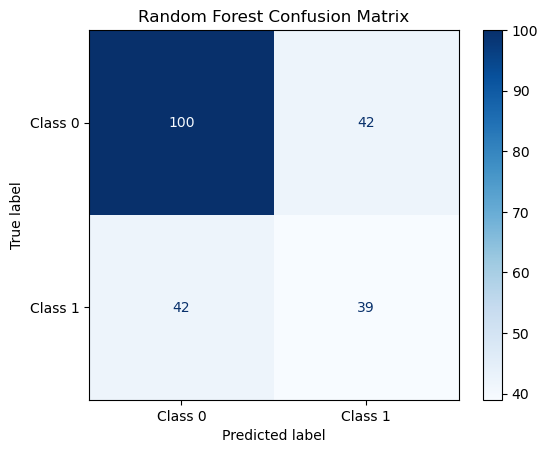

In [32]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Assuming conf_mat is already calculated and you have display_labels
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Class 0", "Class 1"]) # Add your actual class labels
disp.plot(cmap=plt.cm.Blues) # Customize colormap as needed
plt.title("Random Forest Confusion Matrix")
plt.show()